In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET
from os import listdir, mkdir, getcwd
from os.path import join

import time
import json

In [2]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level = True, lower = False, filters = '')

for partition in ['train', 'valid', 'test']:
    file = open(join('dataset', 'ECFR-title14-'+ partition + '.txt'), encoding = 'utf-8')
    tokenizer.fit_on_texts(file)
    file.close()

In [3]:
def make_dataset(partition, tokenizer, sequence_length = None, batch_size = 16, dummy = False, batching_mode = 'regular'):
    
    assert batching_mode in ['regular', 'recurrent_encoding', 'recurrent_embedding']

    # get dataset as list of sequences of tokens
    with open(join('dataset', 'ECFR-title14-' + partition + '.txt'), encoding='utf-8') as file:
        sequences = tokenizer.texts_to_sequences(file)
    
    # make single stream of tokens for the entire dataset
    dataset = [] 
    for paragraph in sequences:
        dataset += paragraph
    
    # get x and y from the full sequence
    dataset = np.array(dataset)
    if dummy == True:  # empty inputs in order to test setup
        x = tf.data.Dataset.from_tensor_slices(np.zeros_like(dataset[:-1]))
    else:
        x = tf.data.Dataset.from_tensor_slices(dataset[:-1])
    y = tf.data.Dataset.from_tensor_slices(dataset[1:])
    
    # zip inputs and labels into tuples
    if batching_mode == 'regular': # dataset will not be batched into sequences (for simple NN)
        dataset = tf.data.Dataset.zip((x,y))
        dataset = dataset.batch(batch_size)
    elif batching_mode == 'recurrent_encoding': # will be batched in individual entries, then sequences, then batches
        dataset = tf.data.Dataset.zip((x,y))
        dataset = dataset.batch(1)
        dataset = dataset.batch(sequence_length, drop_remainder = True)
        dataset = dataset.batch(batch_size, drop_remainder = True)
    elif batching_mode == 'recurrent_embedding': # will be batched into sequences, then batches
        dataset = tf.data.Dataset.zip((x,y))
        dataset = dataset.batch(sequence_length, drop_remainder = True)
        dataset = dataset.batch(batch_size, drop_remainder = True)

    dataset = dataset.prefetch(1)
    
    return dataset

§ 1.1   General defi ...... length = 61808
§ 3.1   Applicabilit ...... length = 299
§ 3.5   Statements a ...... length = 2556
§ 3.200   Effect of  ...... length = 542
§ 3.205   Effect of  ...... length = 863
§ 5.1   Applicabilit ...... length = 797
§ 5.3   General requ ...... length = 972
§ 5.5   Definitions. ...... length = 1570
§ 5.21   Safety poli ...... length = 1059
§ 5.23   Safety acco ...... length = 885
§ 5.25   Designation ...... length = 2124
§ 5.27   Coordinatio ...... length = 627
§ 5.51   Applicabili ...... length = 335
§ 5.53   System anal ...... length = 777
§ 5.55   Safety risk ...... length = 698
§ 5.71   Safety perf ...... length = 1347
§ 5.73   Safety perf ...... length = 824
§ 5.75   Continuous  ...... length = 193
§ 5.91   Competencie ...... length = 273
§ 5.93   Safety comm ...... length = 455
§ 5.95   SMS documen ...... length = 190
§ 5.97   SMS records ...... length = 785
§ 11.1   To what doe ...... length = 237
§ 11.3   What is an  ...... length = 381
§ 11.5   

§§ 91.195-91.199   [ ...... length = 2521
§ 91.205   Powered c ...... length = 7942
§ 91.207   Emergency ...... length = 4959
§ 91.209   Aircraft  ...... length = 1082
§ 91.211   Supplemen ...... length = 2148
§ 91.213   Inoperati ...... length = 4647
§ 91.215   ATC trans ...... length = 4727
§ 91.217   Data corr ...... length = 1229
§ 91.219   Altitude  ...... length = 3244
§ 91.221   Traffic a ...... length = 478
§ 91.223   Terrain a ...... length = 1689
§ 91.225   Automatic ...... length = 6681
§ 91.227   Automatic ...... length = 8495
§§ 91.228-91.299   [ ...... length = 877
§ 91.305   Flight te ...... length = 149
§ 91.307   Parachute ...... length = 2170
§ 91.309   Towing: G ...... length = 2534
§ 91.311   Towing: O ...... length = 233
§ 91.313   Restricte ...... length = 5040
§ 91.315   Limited c ...... length = 180
§ 91.317   Provision ...... length = 3725
§ 91.319   Aircraft  ...... length = 4296
§ 91.321   Carriage  ...... length = 1403
§ 91.323   Increased ...... length = 19

§ 152.201   Applicab ...... length = 168
§ 152.203   Allowabl ...... length = 1713
§ 152.205   United S ...... length = 2348
§ 152.207   Proceeds ...... length = 482
§ 152.209   Grant pa ...... length = 4213
§ 152.211   Grant pa ...... length = 535
§ 152.213   Grant cl ...... length = 2341
§ 152.301   Applicab ...... length = 298
§ 152.303   Financia ...... length = 240
§ 152.305   Accounti ...... length = 755
§ 152.307   Retentio ...... length = 427
§ 152.309   Availabi ...... length = 1161
§ 152.311   Availabi ...... length = 401
§ 152.313   Property ...... length = 525
§ 152.315   Reportin ...... length = 340
§ 152.317   Report o ...... length = 303
§ 152.319   Monitori ...... length = 1724
§ 152.321   Notice o ...... length = 403
§ 152.323   Budget r ...... length = 745
§ 152.325   Financia ...... length = 300
§ 152.401   Applicab ...... length = 1263
§ 152.403   Definiti ...... length = 4947
§ 152.405   Assuranc ...... length = 1774
§ 152.407   Affirmat ...... length = 2249
§ 152.

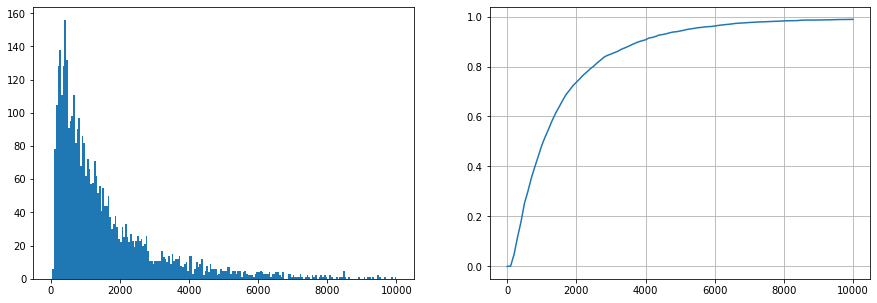

In [435]:
paragraphs = []

with open(join('dataset', 'ECFR-title14-' + 'train' + '.txt'), encoding='utf-8') as file:
    for line in file:
        if line[0] == '§':
            paragraphs.append(line)
        else:
            paragraphs[len(paragraphs)-1] += line

for line in range(len(paragraphs)):
    print('{} ...... length = {}'.format(paragraphs[line][:20], len(paragraphs[line])))
    
lengths = []
[lengths.append(len(p)) for p in paragraphs]
lengths = np.array(lengths)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.hist(lengths, bins = 200, range = (0,10000))

plt.subplot(1,2,2)
density = np.array([(x, (lengths < x).sum() / lengths.shape[0]) for x in np.arange(101)*100])
plt.plot(density[:,0], density[:,1])
plt.grid(axis='both', which='both')
plt.show()

In [567]:
with open(join('dataset', 'ECFR-title14-' + 'train' + '.txt'), encoding='utf-8') as file:
    full_text = file.read()
with open(join('dataset', 'ECFR-title14-' + 'train' + '.txt'), encoding='utf-8') as file:
    sequences = tokenizer.texts_to_sequences(file)

In [598]:
full_sequences = []

for line in sequences:
    full_sequences += line

In [599]:
partition_length = len(full_text)

batch_size = 4 # number of RNN instances, each seeing a piece from a different paragraph
num_paragraphs = batch_size # different name for the same thing
paragraph_length = partition_length // num_paragraphs # characters in each of the batch_size paragraphs
sequence_length = 48 # number of characters in a sequence = number of repetitions of the RNN stack per instance
sequences_per_paragraph = paragraph_length // sequence_length # number of steps to finish paragraph = steps per epoch

In [600]:
def map_fn(paragraph):
    return tf.data.Dataset.from_tensor_slices(paragraph).batch(sequence_length, drop_remainder=True)

In [601]:
dataset = tf.data.Dataset.from_tensor_slices(full_sequences)
dataset = dataset.batch(paragraph_length, drop_remainder = True)
dataset = dataset.interleave(map_fn, cycle_length = num_paragraphs)
dataset = dataset.batch(batch_size, drop_remainder = True)

In [603]:
for item in dataset.take(6):
    for sequence in range(len(item.numpy())):
        print(tokenizer.sequences_to_texts([item.numpy()[sequence]]))
    print()

['§   1 . 1       G e n e r a l   d e f i n i t i o n s . L i n k   t o   a n   a m e n d m e n t']
['a   s a f e   c l i m b o u t   c a n   b e   m a d e   a t   s p e e d s   a l l o w i n g   c']
['p r o v e d   a v i a t i o n   r e d   o r   a v i a t i o n   w h i t e   a n t i c o l l i s']
['h i c h   t h e r e   a r e   n o   d i f f e r e n c e s   i n   t h e   t y p e   d e s i g n']

['  p u b l i s h e d   a t   8 6   F R   4 5 0 3 ,   J a n .   1 5 ,   2 0 2 1 . A s   u s e d  ']
['o m p l i a n c e   w i t h   t h e   c l i m b   r e q u i r e m e n t s   o f   §   2 9 . 6 7']
['i o n   l i g h t   s y s t e m .   I n   t h e   e v e n t   o f   f a i l u r e   o f   a n y']
['  w i t h   r e s p e c t   t o   t h e   i n s t a l l a t i o n   o f   t h e   f i r s t   p']

['i n   S u b c h a p t e r s   A   t h r o u g h   K   o f   t h i s   c h a p t e r ,   u n l e']
['( a ) ( 1 )   a n d   ( 2 ) ;   a n d \n ( c )   T h e   r o t o r c r a f t   d o e s   n o t  